# Machine Learning Project

In this project, I am tring to implement [Generative Adverserarial Nets (GAN)](https://arxiv.org/pdf/1710.07035.pdf)  for digit and Face generation. GAN's are very exciting algorithms and used today from generating celebrity faces,   generating artisting imagesto generate audio signals.

Porting some packages 

In [2]:
import random
import numpy as np
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

Importing Face DataSet and doing preprocessing for model training. For the preprocessing step, I scaled the data from [-0.5, 0.5].

In [14]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# Get images
n_samples, h, w = lfw_people.images.shape
npix = h*w

# Data in 2D form
X = lfw_people.data
n_features = X.shape[1]

print("Image size     = {0:d} x {1:d} = {2:d} pixels".format(h,w,npix))
print("Number faces   = {0:d}".format(n_samples))

Xdigs = 2*(X/255)-1
Xdigs = Xdigs/2

Image size     = 50 x 37 = 1850 pixels
Number faces   = 1288


Function to port few samples from training dataset for training. Ideally it should be train on all the samples 
but it is taking lot of time to train so we took few percentage of data from all the digits

Getting the dataset for traing and printing size

In [15]:
nTrain, nFeatures = Xdigs.shape
print('trainSize', nTrain, 'Features', nFeatures)

trainSize 1288 Features 1850


# Function to display digits

In [19]:
def plt_face(x):
    nrow = h
    ncol = w
    xsq = x.reshape((nrow,ncol))
    plt.imshow(xsq, cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    

Checking Function for displaying

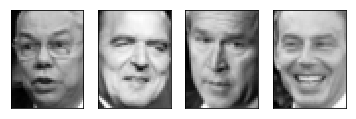

In [21]:
nplt = 4
nsamp = Xdigs.shape[0]
for i in range(nplt):
    ind = randint(0,nsamp-1)
    plt.subplot(1,nplt,i+1)
    plt_face(Xdigs[ind,:])

# importing Keras model layers

In [22]:
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, LeakyReLU
from keras.layers import Conv2D
from keras.layers import Activation
from keras.optimizers import SGD, Adam

import keras.backend as K
K.clear_session()


Using TensorFlow backend.
/home/manoj15/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Model Gereration

# Discriminator Model

This model try to distinguish between samples generated are from real distribution or generated distribution. 

In [27]:
inputShape = (nFeatures,)
dModel = Sequential()
dModel.add(Dense(256, input_shape=inputShape, activation='tanh'))
dModel.add(Dense(256,   activation= 'tanh'))
dModel.add(Dense(1, activation = 'sigmoid'))
dModel.summary()

#Compile the model
#dOpt = Adam(lr=2e-3)
#dModel.compile(loss='binary_crossentropy',optimizer=dOpt,metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               473856    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 539,905
Trainable params: 539,905
Non-trainable params: 0
_________________________________________________________________


# Generator Model

This model tries to generate samples which look like real samples and try to fool the discriminator

In [28]:
randomDim = 100
gModel = Sequential()
gModel.add(Dense(1024, input_shape=(randomDim,), activation='tanh'))
gModel.add(Dense(1024, activation='tanh'))
gModel.add(Dense(nFeatures, activation = 'tanh'))  
  
gModel.summary()

#gOpt = Adam(lr=1e-1)
#gModel.compile(loss='categorical_crossentropy',optimizer=gOpt,metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              103424    
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_12 (Dense)             (None, 1850)              1896250   
Total params: 3,049,274
Trainable params: 3,049,274
Non-trainable params: 0
_________________________________________________________________


# Discriminator Inside Generator 

This model appends discriminator inside the generator for training purposes. 
It is very important here make discriminator layers training false here so that they are 
not training while training generator else they will understand at each step what generator is doing.

In [29]:
gModelTrain = Sequential()
for layer in gModel.layers:
    gModelTrain.add(layer)
    
for layer in dModel.layers:
    layer.trainable = False 
    gModelTrain.add(layer)
       
gModelTrain.summary() 


#gModelTrain.compile(loss='binary_crossentropy',optimizer=gOpt,metrics=['accuracy'])    
#for layer in gModelTrain.layers:
#    print(layer.trainable)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              103424    
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_12 (Dense)             (None, 1850)              1896250   
_________________________________________________________________
dense_7 (Dense)              (None, 256)               473856    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 3,589,179
Trainable params: 3,049,274
Non-trainable params: 539,905
____________________________________________________________

# Model compilation

In [30]:
#compile
gOpt = SGD(lr=1e-4,  momentum=0.9, nesterov=True)
gModel.compile(loss='categorical_crossentropy',optimizer="SGD")

gOptT = SGD(lr=1e-4,  momentum=0.9, nesterov=True)
gModelTrain.compile(loss='binary_crossentropy',optimizer=gOptT)    

for layer in dModel.layers:
    layer.trainable = True
   
dOpt = SGD(lr=1e-4,  momentum=0.9, nesterov=True)
dModel.compile(loss='binary_crossentropy',optimizer=dOpt)


# Function to test generator It also saves the intermediate results

In [32]:
def testGenerator(images, rows, cols, epoch, start):
    noise = np.random.normal(0,1, [images,100])
    out = gModel.predict(noise)
    fig = plt.figure(figsize=(8,8))
    for i in range(images):
        plt.subplot(rows,cols,i+1)
        plt_face((out[i,:]*2 +1)/2)
        
    fig.savefig(str(start+epoch)+'.png')

# Training Models

This function runs Trains both generative and discriminative models per batch. The important things to consider here are:

1). Discriminator model take both real and fake samples in each batch.


2). Generative samples mark samples as Real to fool the discriminator and learn from mistakes.


3). Make sure where the discriminator models layers are training and where not.


4). In paper they talk about training discriminator multiple times but I trained only once due to time constraint.

In [36]:
def runAdversialNet(epochs, batchSize, lossDE, lossGE, accuDE, accuGE, start):
    for i in range(epochs):
        trainIdx = random.sample(range(0,nTrain), nTrain)
        #print(trainIdx)
        lossD = 0
        accuD = 0
        lossG = 0
        accuG = 0
        nBatch = nTrain/batchSize
        for j in range(0, nTrain-batchSize, batchSize):
            #disminicrator Training
            XData = Xdigs[trainIdx[j:j+batchSize],:]  
            noise = np.random.normal(0,1, [batchSize,100])
            gData = gModel.predict(noise)

            trainBatchD = np.concatenate((XData, gData))
            labelD = np.zeros([2*batchSize])
            labelD[0:batchSize] = 1  #Real
            labelD[batchSize:] = 0   #Fake
            
            dModel.trainable = True
            lossDB  = dModel.train_on_batch(trainBatchD, labelD)
            
            #Generator Training
            noiseG = np.random.normal(0,1, [batchSize,100])
            labelG = np.zeros([batchSize])
            #Fake is going Real to fool discriminator
            labelG[0:batchSize] = 1    
            dModel.trainable = False
            lossGB = gModelTrain.train_on_batch(noise, labelG)
            lossD = lossD + lossDB
            lossG = lossG + lossGB
            
        lossDE.append(lossD/(nBatch))
        lossGE.append(lossG/nBatch)
        #print('epoch ', i, 'lossD', lossD/(nBatch), 'accuD', accuD/nBatch, 'lossG', lossG/nBatch, 'accuG', accuG/nBatch)    
        print('epoch ', i, 'lossD', lossD/(nBatch), 'lossG', lossG/nBatch)      
        if(i%10 == 0):
            testGenerator(16, 4, 4, i, start)

Maiintain some logs from plotting

In [37]:
lossDE = []
accuDE = []
lossGE = []
accuGE = []

# Training the model

epoch  0 lossD 0.662729848246 lossG 0.696424944801
epoch  1 lossD 0.624417347938 lossG 0.6498308241
epoch  2 lossD 0.594532335767 lossG 0.627532868652
epoch  3 lossD 0.587554081627 lossG 0.589071219012
epoch  4 lossD 0.581254072071 lossG 0.566271992204
epoch  5 lossD 0.582685023361 lossG 0.540939280705
epoch  6 lossD 0.585222174662 lossG 0.521578300073
epoch  7 lossD 0.582677968541 lossG 0.512070161956
epoch  8 lossD 0.589621548327 lossG 0.49445138955
epoch  9 lossD 0.590152388034 lossG 0.485788005479
epoch  10 lossD 0.596489582003 lossG 0.473035602096
epoch  11 lossD 0.599452391915 lossG 0.466755636731
epoch  12 lossD 0.598765821931 lossG 0.463902316478
epoch  13 lossD 0.60252431757 lossG 0.456910330316
epoch  14 lossD 0.60211798271 lossG 0.455992943011
epoch  15 lossD 0.602975137485 lossG 0.454157639734
epoch  16 lossD 0.600458393926 lossG 0.456523468035
epoch  17 lossD 0.603546419499 lossG 0.453004287637
epoch  18 lossD 0.597866860976 lossG 0.460635300749
epoch  19 lossD 0.599173234

/home/manoj15/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


epoch  201 lossD 0.662964659448 lossG 0.944918508115
epoch  202 lossD 0.662183084843 lossG 0.94585265284
epoch  203 lossD 0.662791040373 lossG 0.941993326874
epoch  204 lossD 0.660530068119 lossG 0.946556880607
epoch  205 lossD 0.662091265554 lossG 0.93954907441
epoch  206 lossD 0.662721186691 lossG 0.934822350555
epoch  207 lossD 0.661928088028 lossG 0.937839020853
epoch  208 lossD 0.662613624371 lossG 0.934513277149
epoch  209 lossD 0.663735933185 lossG 0.928231972345
epoch  210 lossD 0.665435727339 lossG 0.923003424769
epoch  211 lossD 0.6669586386 lossG 0.918597567896
epoch  212 lossD 0.667257525166 lossG 0.918573169234
epoch  213 lossD 0.671245976264 lossG 0.907769887344
epoch  214 lossD 0.67489255141 lossG 0.900628694096
epoch  215 lossD 0.678151520143 lossG 0.892628181055
epoch  216 lossD 0.68168454733 lossG 0.885905865557
epoch  217 lossD 0.685311169358 lossG 0.880415641003
epoch  218 lossD 0.687419147965 lossG 0.878239800471
epoch  219 lossD 0.690845221466 lossG 0.870891763557

TypeError: testGenerator() missing 1 required positional argument: 'start'

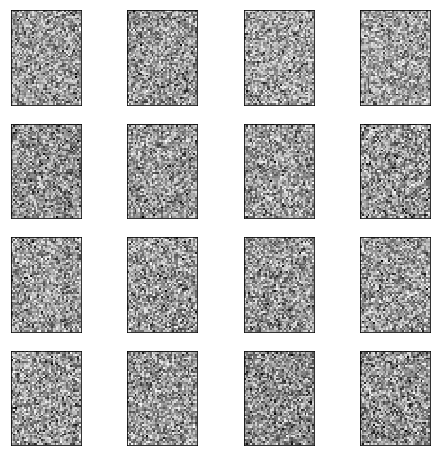

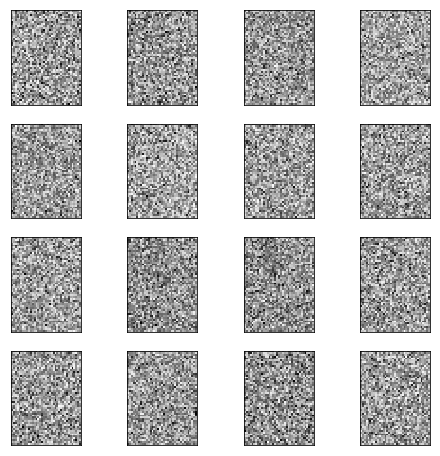

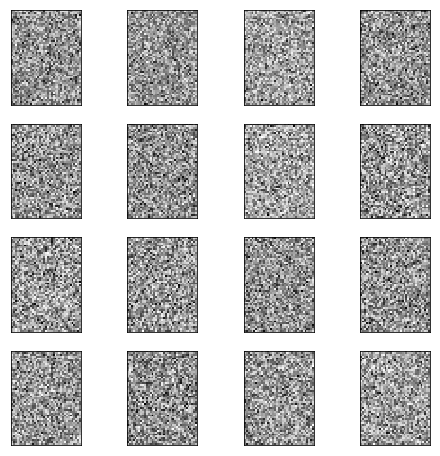

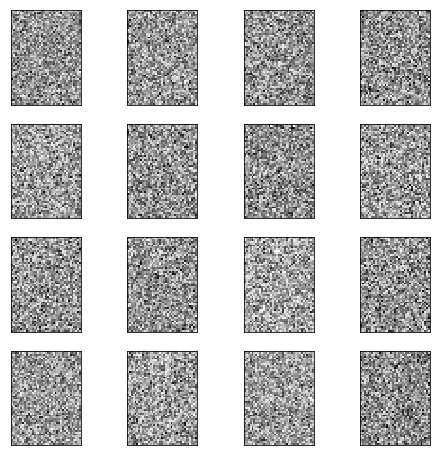

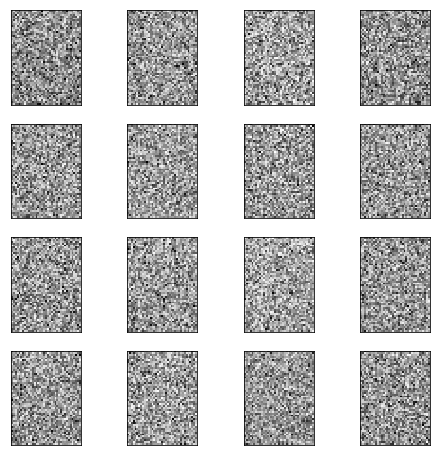

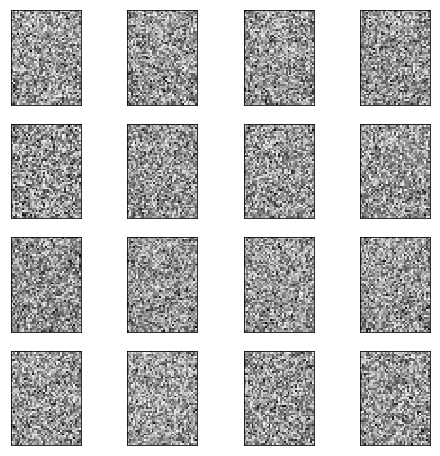

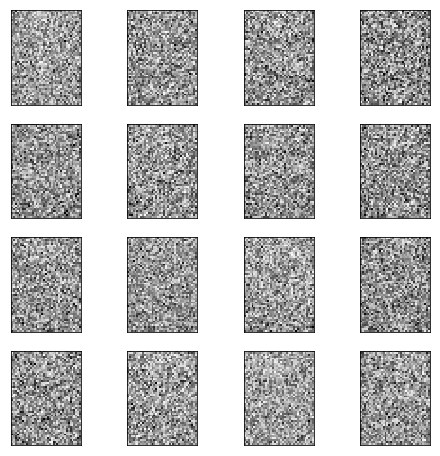

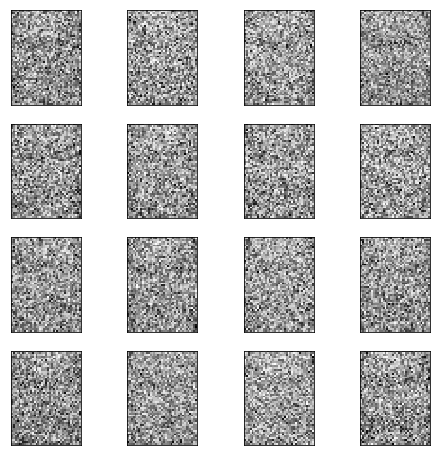

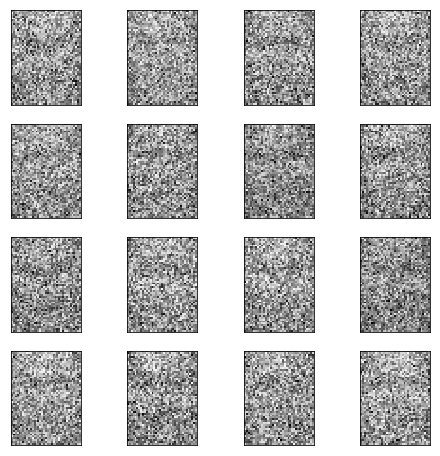

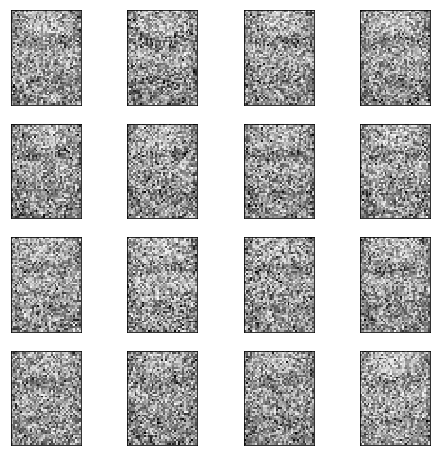

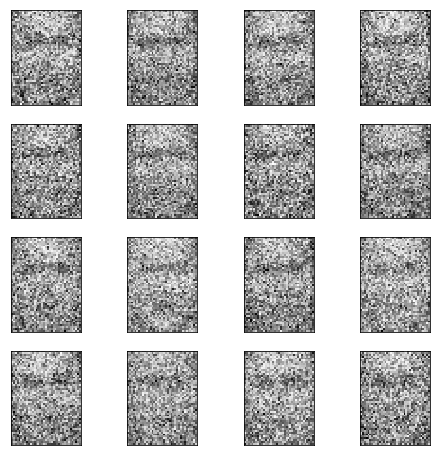

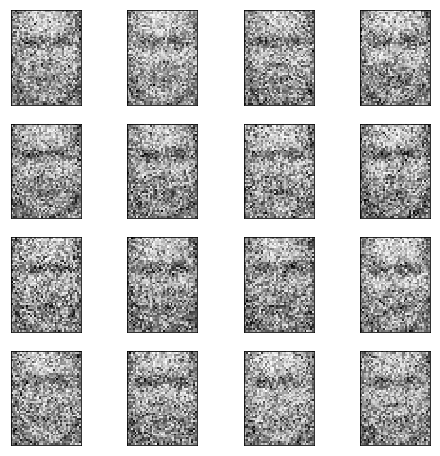

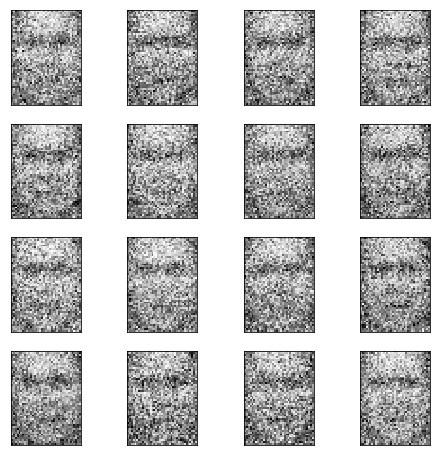

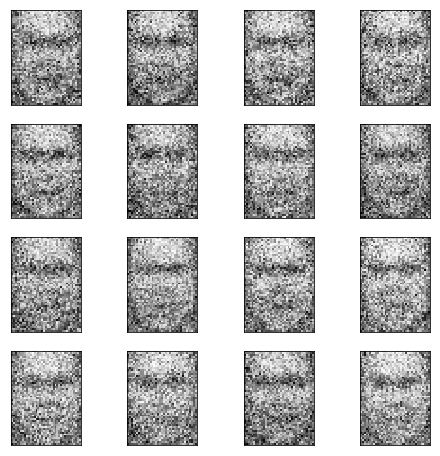

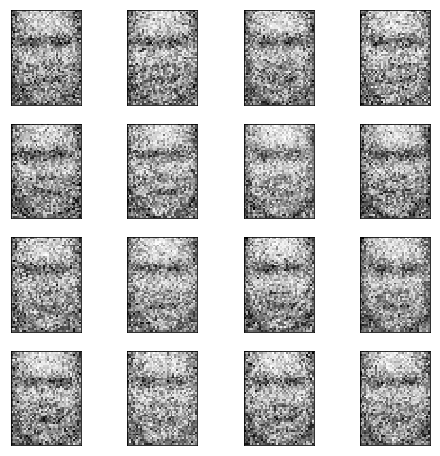

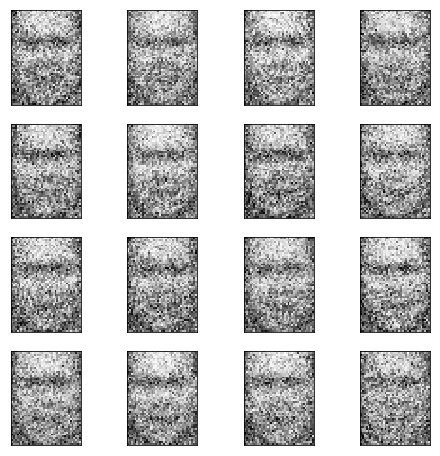

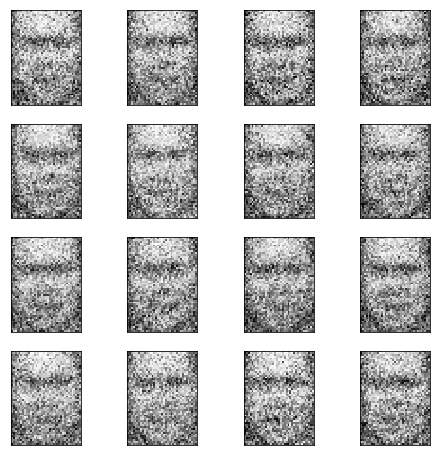

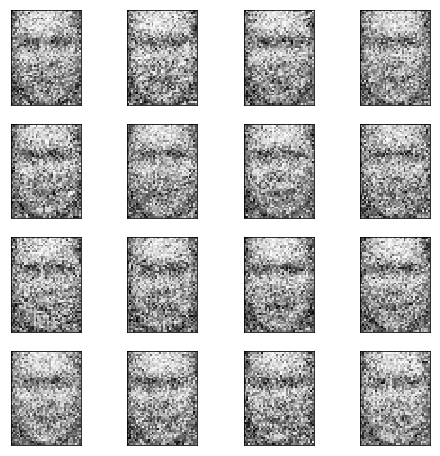

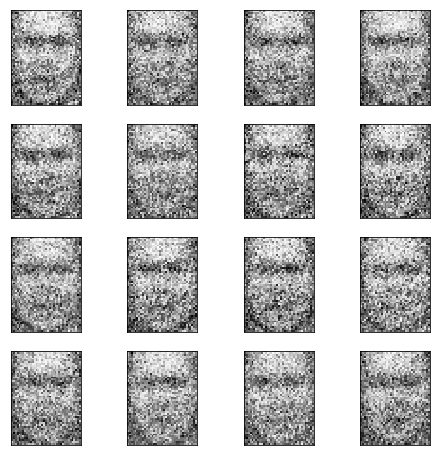

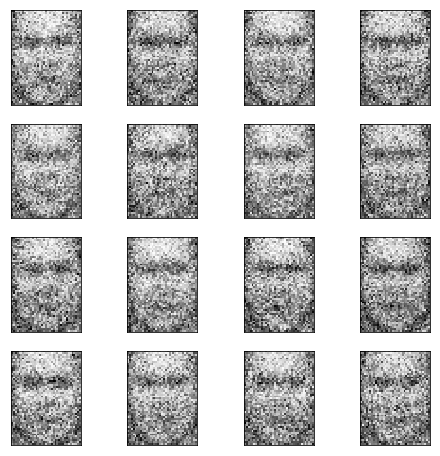

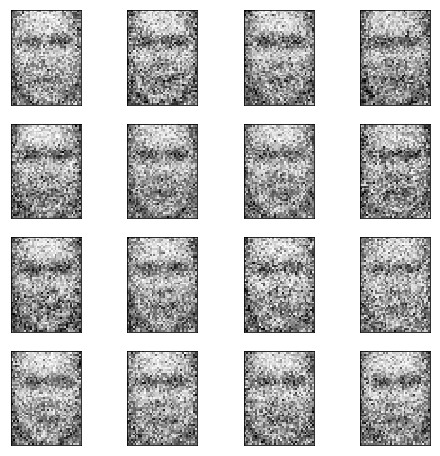

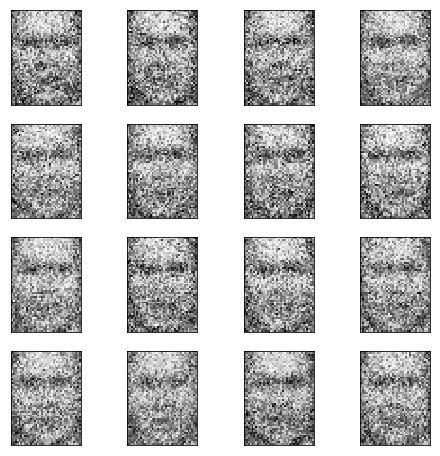

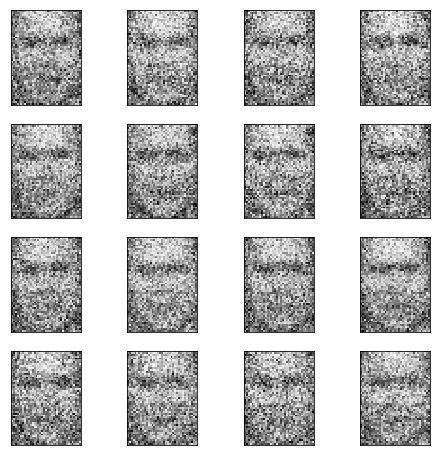

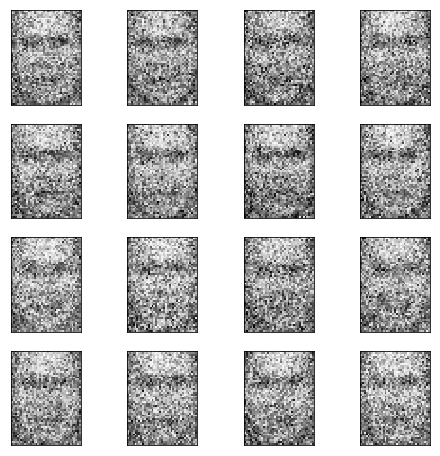

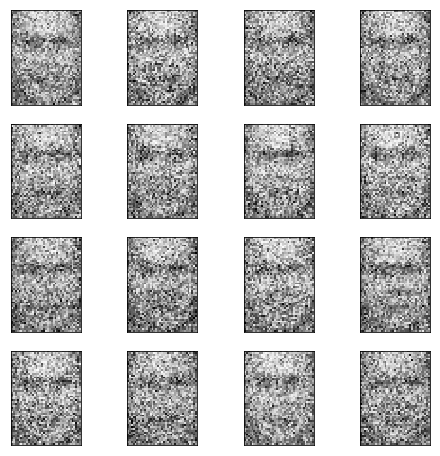

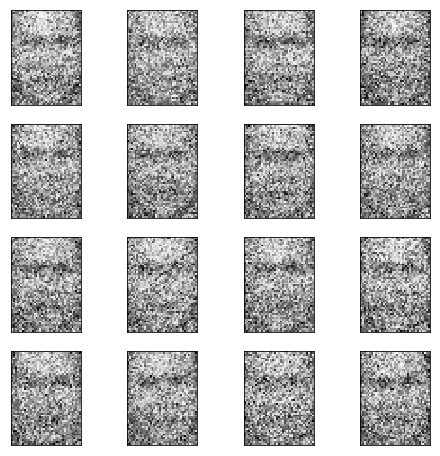

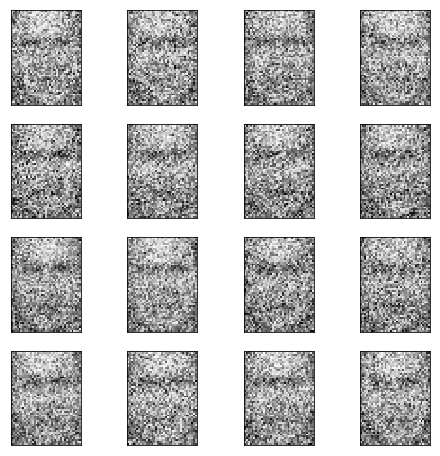

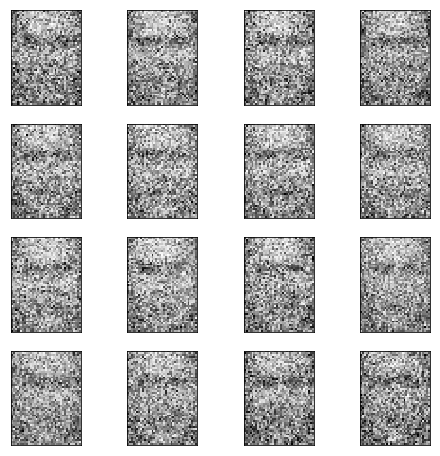

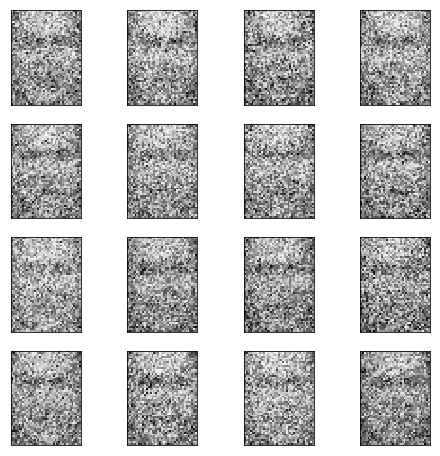

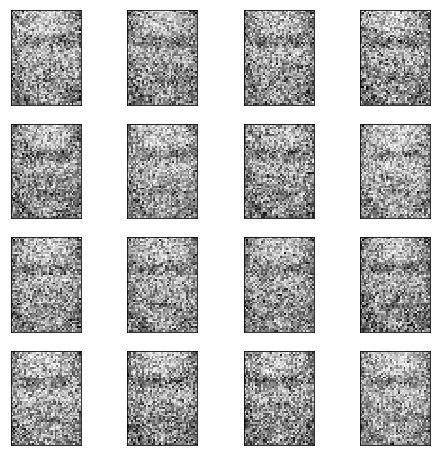

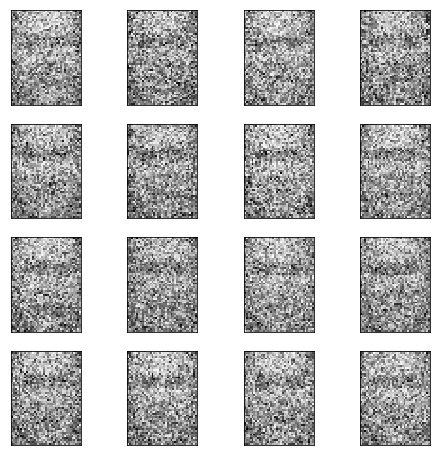

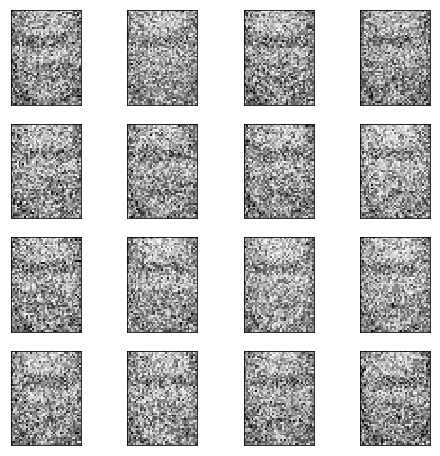

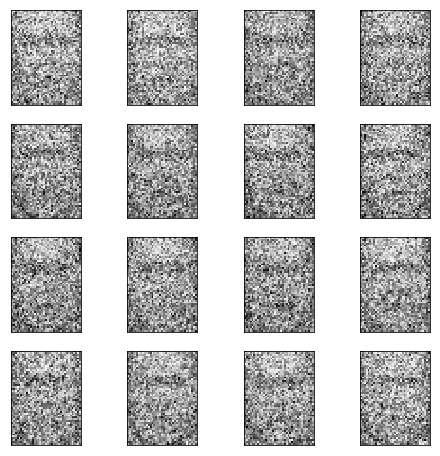

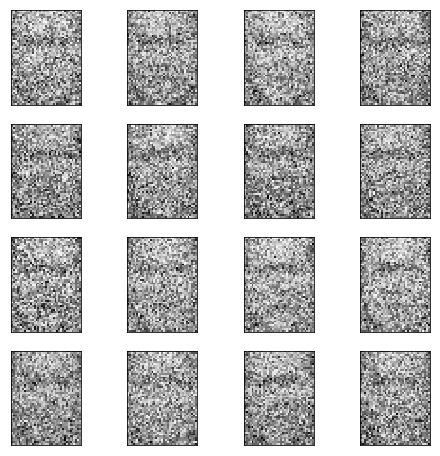

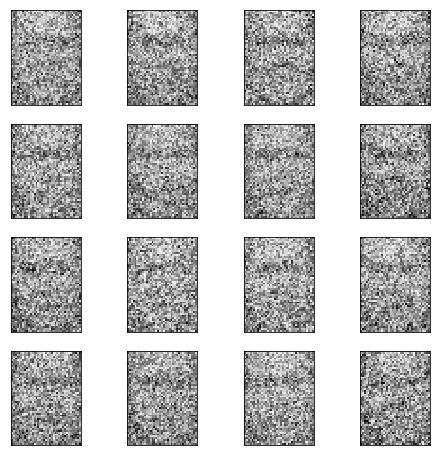

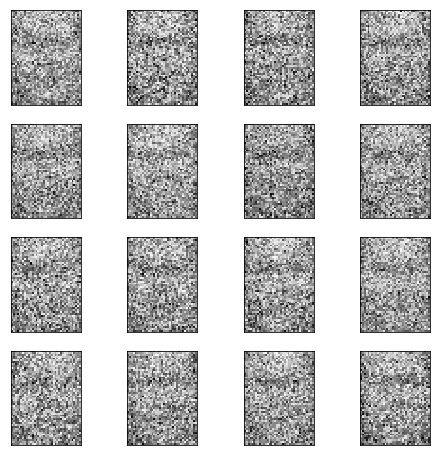

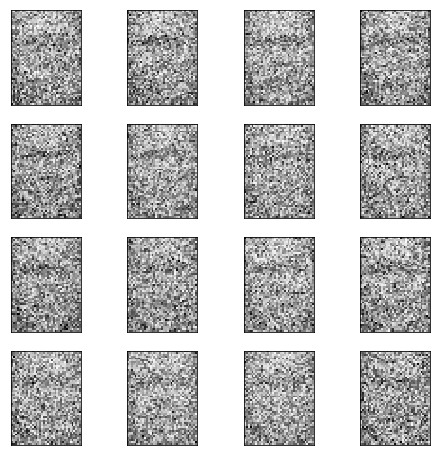

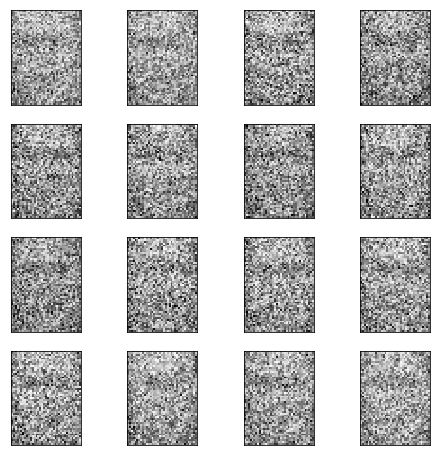

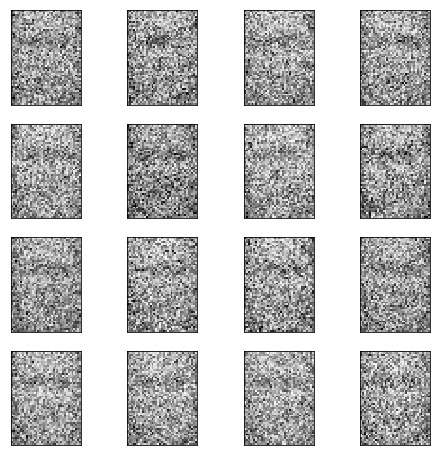

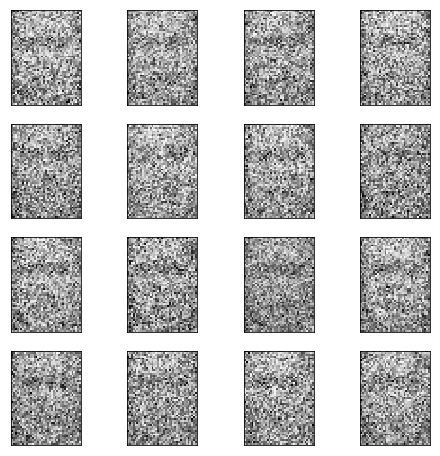

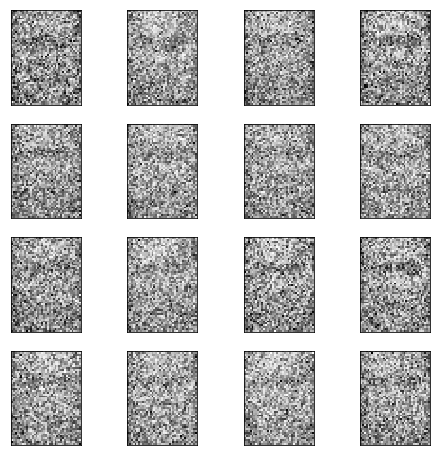

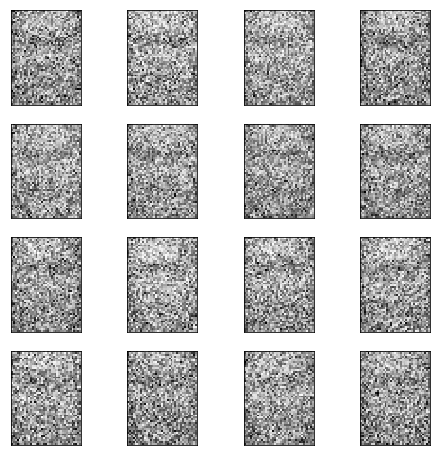

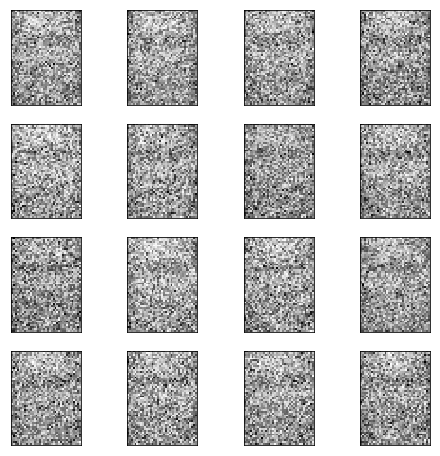

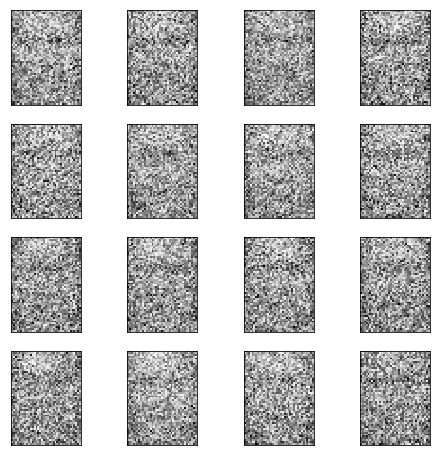

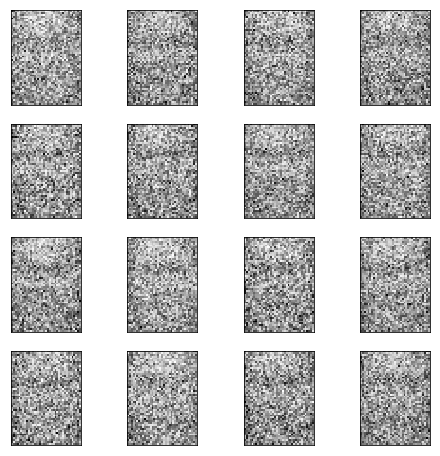

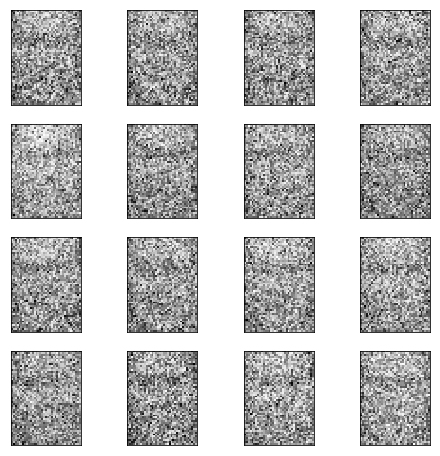

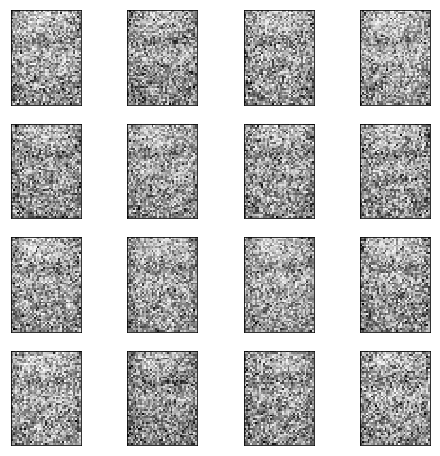

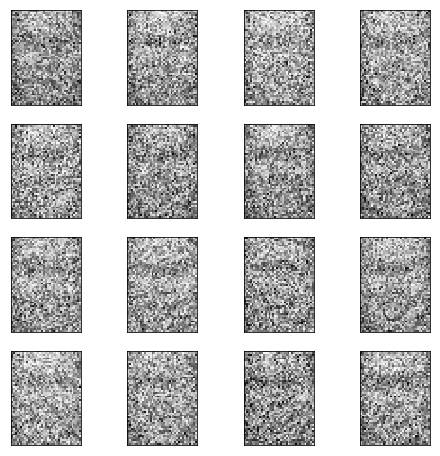

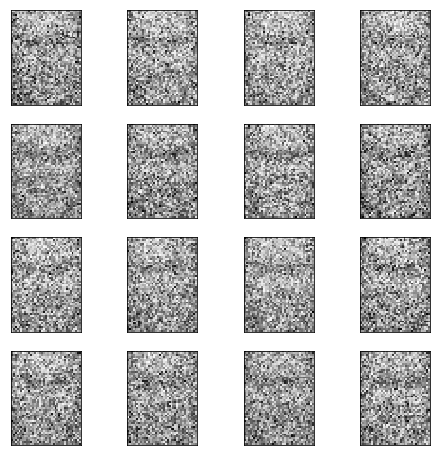

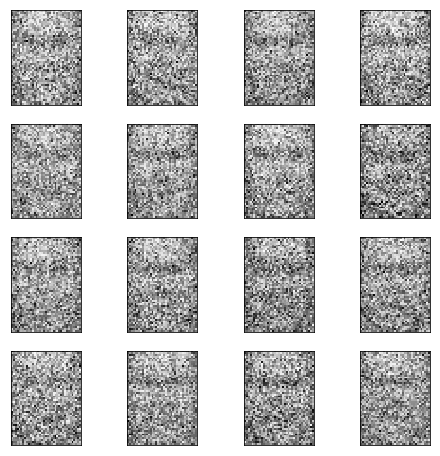

In [38]:
start = 0
epochs = 500
runAdversialNet(epochs, 32, lossDE, lossGE, accuDE, accuGE, start)
testGenerator(16, 4, 4, start)

fig = plt.figure()
plt.plot(lossDE, 'r')
plt.plot(lossGE, 'g')
fig.savefig(str(epoch)+'_loss.png')

# Test Generator

In [ ]:
testGenerator(16, 4, 4, 500, 0)

# Plotting loss

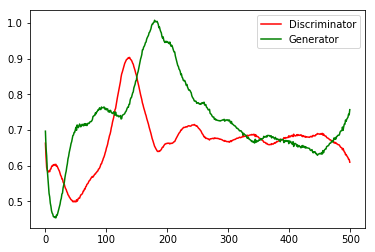

In [39]:
fig = plt.figure()
plt.plot(lossDE, 'r')
plt.plot(lossGE, 'g')
plt.legend(['Discriminator', 'Generator'])
fig.savefig(str(1000)+'_loss.png')